<a href="https://colab.research.google.com/github/ShivangModi/StockStalkers/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
tick = yf.Ticker("AAPL")

tick.info
data_1 = tick.history(period="max")
df =pd.DataFrame(data_1['Close'])
df.columns=['Value']

In [ ]:
df

,Value
Date,
1980-12-12,0.100323
1980-12-15,0.095089
1980-12-16,0.088110
1980-12-17,0.090291
1980-12-18,0.092908
...,...
2022-03-15,155.089996
2022-03-16,159.589996
2022-03-17,160.619995


In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  #res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

FIND d VALUE

In [ ]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -30.32037434789792
p-value : 0.0
Number of Lags Used : 35
Number of Observations Used : 10357
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
# print(df_testing.to_string())
#df_testing.plot()

In [ ]:
#Auto Correlation & Partial Auto Correlation Graph
#ACF = plot_acf(df_testing.dropna(),lags=50)
#PACF = plot_pacf(df_testing.dropna(),lags=50)

calculate the error on the test-set for each p, and pick the best one.

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

The RMSE is : 0.024624797235217738 , Value of p :  1
The RMSE is : 0.02462891444872594 , Value of p :  2
The RMSE is : 0.024601256790163156 , Value of p :  3
The RMSE is : 0.024604902073379415 , Value of p :  4
The RMSE is : 0.024603482976814688 , Value of p :  5
The RMSE is : 0.024614682112665258 , Value of p :  6
The RMSE is : 0.024639667892304425 , Value of p :  7
The RMSE is : 0.02460970987011535 , Value of p :  8
The RMSE is : 0.02458697719187429 , Value of p :  9
The RMSE is : 0.024587164758120762 , Value of p :  10
The RMSE is : 0.024590550002254814 , Value of p :  11
The RMSE is : 0.02194067656515461 , Value of p :  12
The RMSE is : 0.021981974693882342 , Value of p :  13
The RMSE is : 0.02197220346227468 , Value of p :  14
The RMSE is : 0.02196976677187429 , Value of p :  15
The RMSE is : 0.021980679013795166 , Value of p :  16
The RMSE is : 0.02198259154972777 , Value of p :  17
The RMSE is : 0.02198095276592673 , Value of p :  18
The RMSE is : 0.02200198803418413 , Value of 

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.02194067656515461 , Value of p :  12


In [ ]:
df_c = pd.concat([df_train,df_test])
#df_c[['Value','Predicted_Values']].plot()

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [ ]:
res

,Residuals
Date,
1981-01-20,-0.010073
1981-01-21,0.068099
1981-01-22,0.023267
1981-01-23,0.001320
1981-01-26,-0.030022
...,...
2022-03-15,0.012985
2022-03-16,0.023817
2022-03-17,0.022192


In [ ]:
#res.plot(kind='kde')

FIND q VALUE

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 0.021974442685850516 , Value of q :  1
The RMSE is : 0.0219719608273317 , Value of q :  2
The RMSE is : 0.02197124946922627 , Value of q :  3
The RMSE is : 0.02196975768934945 , Value of q :  4
The RMSE is : 0.021968239636915007 , Value of q :  5
The RMSE is : 0.021975535730753292 , Value of q :  6
The RMSE is : 0.021987219134060567 , Value of q :  7
The RMSE is : 0.021980415683318873 , Value of q :  8
The RMSE is : 0.02198615880927425 , Value of q :  9
The RMSE is : 0.02198137303232457 , Value of q :  10
The RMSE is : 0.02198988019350179 , Value of q :  11
The RMSE is : 0.021724908201283442 , Value of q :  12
12


In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

The RMSE is : 0.021724908201283442 , Value of q :  12
[[ 0.00682787]
 [ 0.00045681]
 [-0.00137599]
 [-0.00430006]
 [ 0.00341821]
 [ 0.00606741]
 [-0.00302909]
 [-0.00284698]
 [-0.00357836]
 [-0.00657308]
 [-0.00680663]
 [-0.15893282]]
[1.81445967e-05]


In [ ]:
res_c = pd.concat([res_train,res_test])

In [ ]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Date,,,,,,,,,,,,,,
1981-02-05,0.012291,0.016483,0.052190,-0.073758,-0.101563,-0.045173,-0.046558,-0.059812,-0.030022,0.001320,0.023267,0.068099,-0.010073,0.001502
1981-02-06,0.007207,0.012291,0.016483,0.052190,-0.073758,-0.101563,-0.045173,-0.046558,-0.059812,-0.030022,0.001320,0.023267,0.068099,-0.010838
1981-02-09,-0.038999,0.007207,0.012291,0.016483,0.052190,-0.073758,-0.101563,-0.045173,-0.046558,-0.059812,-0.030022,0.001320,0.023267,-0.004069
1981-02-10,0.024405,-0.038999,0.007207,0.012291,0.016483,0.052190,-0.073758,-0.101563,-0.045173,-0.046558,-0.059812,-0.030022,0.001320,0.000389
1981-02-11,-0.019412,0.024405,-0.038999,0.007207,0.012291,0.016483,0.052190,-0.073758,-0.101563,-0.045173,-0.046558,-0.059812,-0.030022,0.006636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15,0.012985,-0.032797,-0.007879,-0.009896,0.034391,-0.001951,-0.034543,-0.062396,-0.001344,0.029268,0.007331,-0.000805,0.008593,-0.001880
2022-03-16,0.023817,0.012985,-0.032797,-0.007879,-0.009896,0.034391,-0.001951,-0.034543,-0.062396,-0.001344,0.029268,0.007331,-0.000805,0.000424
2022-03-17,0.022192,0.023817,0.012985,-0.032797,-0.007879,-0.009896,0.034391,-0.001951,-0.034543,-0.062396,-0.001344,0.029268,0.007331,-0.000587


In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values

In [ ]:
#df_c[['Value','Predicted_Values']].plot()

In [ ]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [ ]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Date,,,,,,,,,,,,,,
1981-01-20,0.111228,0.087603,0.016573,0.006216,-0.084204,-0.087509,-0.049207,0.004800,-0.079688,-0.072148,-0.069916,0.054254,0.064509,NaN
1981-01-21,0.113409,-0.041816,0.087603,0.016573,0.006216,-0.084204,-0.087509,-0.049207,0.004800,-0.079688,-0.072148,-0.069916,0.054254,NaN
1981-01-22,0.114717,0.041394,-0.041816,0.087603,0.016573,0.006216,-0.084204,-0.087509,-0.049207,0.004800,-0.079688,-0.072148,-0.069916,NaN
1981-01-23,0.114281,0.056937,0.041394,-0.041816,0.087603,0.016573,0.006216,-0.084204,-0.087509,-0.049207,0.004800,-0.079688,-0.072148,NaN
1981-01-26,0.112536,0.039760,0.056937,0.041394,-0.041816,0.087603,0.016573,0.006216,-0.084204,-0.087509,-0.049207,0.004800,-0.079688,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-15,155.089996,-0.043464,0.002005,-0.009590,0.043799,0.009754,-0.022613,-0.041468,-0.003405,0.040805,0.012186,-0.006623,-0.005416,152.801544
2022-03-16,159.589996,0.016363,-0.043464,0.002005,-0.009590,0.043799,0.009754,-0.022613,-0.041468,-0.003405,0.040805,0.012186,-0.006623,155.900004
2022-03-17,160.619995,0.026966,0.016363,-0.043464,0.002005,-0.009590,0.043799,0.009754,-0.022613,-0.041468,-0.003405,0.040805,0.012186,157.002599


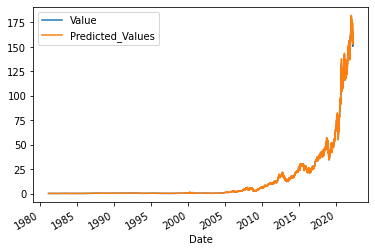

In [ ]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()